1. Попробуйте улучшить работу нейронной сети (разобранную на уроке), обучавшейся на датасет Fashion-MNIST. Напишите в комментариях к уроку, какого результата вы добились от нейросети и что помогло улучшить её точность.
2. Попробуйте найти полезные команды TensorFlow, неразобранные на уроке

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.6 MB/s eta 0:00:00


План по улучшению:
 - Составить несколько моделей с разными параметрами;
 - Поискать оптимальные варианты;
 - Применить несколько разных оптимайзеров;
 - Применить callback;
 - Сделать сборку предсказаний из нескольких моделей (Идея обучить одну из моделей на обратном векторе);

In [1]:
# from __future__ import absolute_import,division, print_function, unicode_literals

#TensorFlow and tf.keras
import tensorflow as tf
tf.random.set_seed(5)
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical, to_ordinal
from tensorflow.keras.models import load_model
#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import keras_tuner as kt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score

print(tf.__version__)

2.15.0


## Импортируем Fashion MNIST датасет

In [2]:
from keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize.
train_images = (train_images / 255)
test_images = (test_images / 255)

# Flatten.
# train_images = train_images.reshape((-1, 784)) # можно использовать np.ravel()
# test_images = test_images.reshape((-1, 784))

4422102/4422102 [==============================] - 0s 0us/step


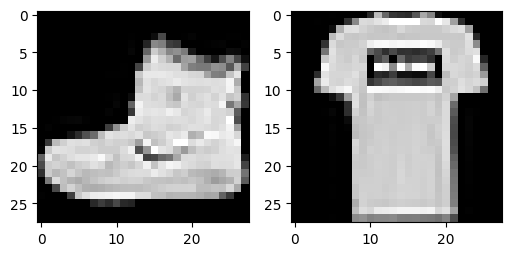

In [3]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(train_images[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(train_images[1], cmap='gray')

Датасет содержит следующие классы:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Каждому классу обозначенному цифрой мы можем присвоить текстовое значение -

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Для процесса обучения нейронной сети нам важно перевести данные из диапазона от 0 до 255 в диапазон от 0 до 1:

### Определение слоев

Давайте создадим 3 слоя нейронной сети с помощью функционала Keras.layers

In [5]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='input'),
    keras.layers.Dense(256, activation='relu', name='hiden_one'),
    keras.layers.Dense(128, activation='relu', name='hiden_two'),
    keras.layers.Dense(64, activation='tanh', name='hiden_three'),
    keras.layers.Dense(64, activation='relu', name='hiden_four'),
    keras.layers.Dense(10, name='output')
])
config = model.get_config()
model.save_weights('fashion_weights.h5')

313/313 - 1s - loss: 0.3481 - accuracy: 0.8917 - 735ms/epoch - 2ms/step

Test accuracy: 0.891700029373169
313/313 [==============================] - 1s 2ms/step


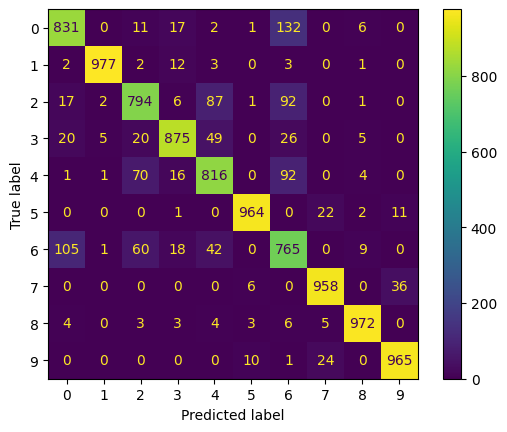

In [6]:
model = model.from_config(config)
model.load_weights('fashion_weights.h5')


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size = 250, epochs=25, verbose=0)
  # model.fit(train_images, train_labels, batch_size = 250, epochs=el, verbose=0, validation_data=(test_images, test_labels))
  # model.fit(train_images, train_labels, batch_size = 10, epochs=10, verbose=0, validation_data=(test_images, test_labels), callbacks=[reduce_lr])
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
  # Получим предсказания
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
# Посмотрим на результаты
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

In [7]:
def recall_precision(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
  precision = precision_score(y_true, y_pred, labels=labels, average=None)
  recall = recall_score(y_true, y_pred, labels=labels, average=None)
  for i, el in enumerate(zip(precision, recall)):
    print(f'Класс - {i}, точность - {el[0]:.3f}, полнота - {el[1]:.3f}')

In [8]:
recall_precision(test_labels, y_pred)

Класс - 0, точность - 0.848, полнота - 0.831
Класс - 1, точность - 0.991, полнота - 0.977
Класс - 2, точность - 0.827, полнота - 0.794
Класс - 3, точность - 0.923, полнота - 0.875
Класс - 4, точность - 0.814, полнота - 0.816
Класс - 5, точность - 0.979, полнота - 0.964
Класс - 6, точность - 0.685, полнота - 0.765
Класс - 7, точность - 0.949, полнота - 0.958
Класс - 8, точность - 0.972, полнота - 0.972
Класс - 9, точность - 0.954, полнота - 0.965


После перебора всех параметров нейросети, созданной на уроке можно уверенно заключить:
- Улучшить ее работу только изменяя параметры невозможно.

- Не улучшает ситуацию последовательное обучение с использованием различных входных пакетов.

- Не удалось также создать сеть с другим количеством слоёв существенно превосходящую образец.

- Не оправдала себя идея использовать для обучения зеркально (горизонтально или вертикально) отраженные изображения.

**-Единственный вариант давший небольшие улучшения это использование комбинации 2х сетей, сети образца и сети с параметрами, которая "заточена" максимально хорошо предсказывать самый плохо определяемый класс.**

313/313 - 1s - loss: 0.3521 - accuracy: 0.8914 - 655ms/epoch - 2ms/step

Test accuracy: 0.8913999795913696
313/313 [==============================] - 1s 2ms/step
313/313 - 1s - loss: 0.3353 - accuracy: 0.8932 - 660ms/epoch - 2ms/step

Test accuracy: 0.8931999802589417
313/313 [==============================] - 1s 2ms/step
0.8991
Класс - 0, точность - 0.832, полнота - 0.869
Класс - 1, точность - 0.993, полнота - 0.980
Класс - 2, точность - 0.839, полнота - 0.796
Класс - 3, точность - 0.921, полнота - 0.893
Класс - 4, точность - 0.807, полнота - 0.851
Класс - 5, точность - 0.979, полнота - 0.964
Класс - 6, точность - 0.744, полнота - 0.735
Класс - 7, точность - 0.949, полнота - 0.961
Класс - 8, точность - 0.977, полнота - 0.976
Класс - 9, точность - 0.955, полнота - 0.966
None


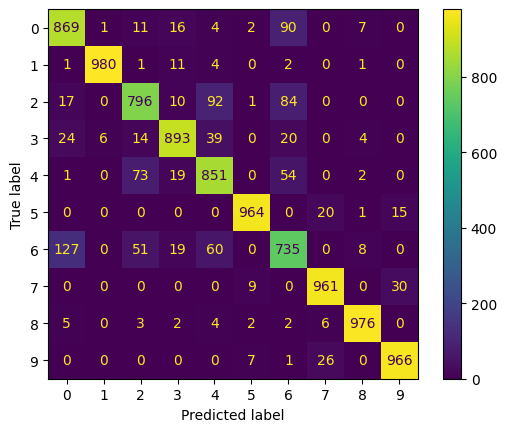

In [9]:
# Создаем словарь который будет содержать модель сети и параметры для обучения
models = dict()
models[0] = [keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='input'),
    keras.layers.Dense(256, activation='relu', name='hiden_one'),
    keras.layers.Dense(128, activation='relu', name='hiden_two'),
    keras.layers.Dense(64, activation='tanh', name='hiden_three'),
    keras.layers.Dense(64, activation='relu', name='hiden_four'),
    keras.layers.Dense(10, name='output')
]), tf.keras.optimizers.Adam(learning_rate=0.001), 250]
models[1] = [keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='input'),
    keras.layers.Dense(256, activation='relu', name='hiden_one'),
    keras.layers.Dense(128, activation='gelu', name='hiden_two'),
    keras.layers.Dense(64, activation='sigmoid', name='hiden_three'),
    keras.layers.Dense(64, activation='selu', name='hiden_four'),
    keras.layers.Dense(10, name='output')]), tf.keras.optimizers.AdamW(learning_rate=0.001), 450]
# Список для сохранения результатов
result = list()
# Формируем сеть.
for key, param in models.items():
  # Загружаем параметры
  model, opt, batch = param[0], param[1], param[2]
  # Загружаем входные веса, чтобы хоть как-то "уравнять" результаты работы
  model.load_weights('fashion_weights.h5')
  model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  model.fit(train_images, train_labels, batch_size=batch, epochs=25, verbose=0)
  # Получаем предварительную метрику
  test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
  print('\nTest accuracy:', test_acc)
  probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])
  # Сохраняем массив с вероятностями
  result.append(probability_model.predict(test_images))
# Получаем финишное предсказание суммируя два массива с вероятностями
y_pred = np.argmax(sum(result), axis=1)
# Окончательная метрика качества
print(accuracy_score(test_labels, y_pred))
# Распределение предсказаний по классам
print(recall_precision(test_labels, y_pred))
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)


Интересным показался модуль Keras-tuner, для подбора оптимальных параметорв сети. Правда я не разобрался как можно с его помощью искать оптимальное число слоёв сети.

In [14]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [15]:
import keras_tuner as kt

In [16]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=10, max_value=256, step=25)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


In [17]:
tuner.search(train_images, train_labels, epochs=25, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f' layer is {best_hps.get("units")}')




Trial 9 Complete [00h 00m 12s]
val_accuracy: 0.8694999814033508

Best val_accuracy So Far: 0.8697500228881836
Total elapsed time: 00h 02m 26s
 layer is 185


# ДОМАШНЕЕ ЗАДАНИЕ

In [18]:
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

# Функция для построения модели
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))  # Входной слой

    # Настройка количества слоев
    hp_layers = hp.Int('num_layers', min_value=1, max_value=5, step=1)  # Гиперпараметр для количества слоев
    for i in range(hp_layers):
        hp_units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32)  # Гиперпараметр для количества нейронов в слое
        model.add(keras.layers.Dense(units=hp_units, activation='relu'))  # Добавление Dense слоя с ReLU активацией

    model.add(keras.layers.Dense(10, activation='softmax'))  # Выходной слой с функцией активации softmax

    # Настройка скорости обучения для оптимизатора
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])  # Гиперпараметр для скорости обучения

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),  # Компиляция модели
                  loss='sparse_categorical_crossentropy',  # Функция потерь
                  metrics=['accuracy'])  # Метрика точности

    return model

# Создание объекта для поиска гиперпараметров
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',  # Оптимизируем по точности на валидационном наборе данных
                     max_epochs=10,  # Максимальное количество эпох
                     factor=3,  # Фактор уменьшения для пропуска моделей
                     directory='my_dir',  # Директория для сохранения результатов поиска
                     project_name='intro_to_kt')  # Название проекта

# Остановка раннего обучения
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Поиск оптимальных гиперпараметров
tuner.search(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Получение оптимальных гиперпараметров
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Оптимальное количество слоев: {best_hps.get('num_layers')}")


Trial 30 Complete [00h 00m 52s]
val_accuracy: 0.8629166483879089

Best val_accuracy So Far: 0.8922500014305115
Total elapsed time: 00h 16m 15s
Оптимальное количество слоев: 1


Поиск оптимальной архитектуры НС для классификации изображений. После обучения и подбора гиперпараметров мы достигли улучшения точности на валидационном наборе данных:
- использовали поиск по сетке гиперпараметров с помощью библиотеки Keras Tuner для оптимизации архитектуры НС.
- Для оценки качества модели использовалась точность на валидационном наборе данных (val_accuracy).
- После поиска оптимальных гиперпараметров мы получили информацию о наилучшей архитектуре сети и её параметрах.
- Результаты обучения и поиска гиперпараметров были сохранены в директории 'my_dir' под названием 'intro_to_kt'.

# Попробуйте обучить нейронную сеть на TensorFlow 2 на датасете imdb_reviews.

In [19]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Загрузка данных
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# Предварительная обработка данных
maxlen = 200  # Максимальная длина последовательности слов
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Создание модели
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(train_data, train_labels, epochs=10, batch_size=128, validation_split=0.2)

# Оценка модели на тестовых данных
loss, accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy:", accuracy)


17464789/17464789 [==============================] - 0s 0us/step
Epoch 1/10
157/157 [==============================] - 23s 135ms/step - loss: 0.5565 - accuracy: 0.6996 - val_loss: 0.3330 - val_accuracy: 0.8610
Epoch 2/10
157/157 [==============================] - 12s 78ms/step - loss: 0.2202 - accuracy: 0.9154 - val_loss: 0.3061 - val_accuracy: 0.8710
Epoch 3/10
157/157 [==============================] - 7s 45ms/step - loss: 0.0964 - accuracy: 0.9735 - val_loss: 0.3334 - val_accuracy: 0.8742
Epoch 4/10
157/157 [==============================] - 5s 34ms/step - loss: 0.0317 - accuracy: 0.9954 - val_loss: 0.3893 - val_accuracy: 0.8664
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.0113 - accuracy: 0.9992 - val_loss: 0.4198 - val_accuracy: 0.8690
Epoch 6/10
157/157 [==============================] - 2s 16ms/step - loss: 0.0048 - accuracy: 0.9998 - val_loss: 0.4518 - val_accuracy: 0.8684
Epoch 7/10
157/157 [==============================] - 3s 16ms/step - loss:

Результаты:
Точность на тестовом наборе данных составляет примерно 86,7%.
